# SUP ML 2 - MODEL

# Libraries

In [ ]:
try:
    import catboost
except ImportError:
    !pip install catboost
    import catboost

In [ ]:
try:
    import shap
except ImportError:
    !pip install shap
    import shap

In [ ]:
# Datos
import pandas as pd
import numpy as np
import pickle

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Métricas Clasificación
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import shap
from scipy.stats import uniform, randint

# Modelos a Entrenar
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# inhabilita warnings
import warnings
warnings.filterwarnings("ignore")

# Carga clean data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DSC N°1123 - Entregable 2 - Julià_Tizzard_Quenti/data/final_df_clean.csv')

In [ ]:
print('Rows: ', df.shape[0], '  Columns: ', df.shape[1], '\n')
df.head(2)

Rows:  90000   Columns:  116 



,Customer_ID,mou,totmrc,change_mou,drop_vce,drop_dat,blck_vce,blck_dat,unan_vce,unan_dat,...,HHstatin_UNKNOWN,ethnic_G,ethnic_H,ethnic_I,ethnic_N,ethnic_O,ethnic_OTHER,ethnic_S,ethnic_U,ethnic_Z
0,1000001,219.25,22.500,-157.25,0.666667,0.0,0.666667,0.0,6.333333,0.0,...,0,0,0,0,1,0,0,0,0,0
1,1000002,482.75,37.425,532.25,8.333333,0.0,1.000000,0.0,61.333333,0.0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
# Columna Customer_ID transformada a índice
df=df.set_index('Customer_ID')
print('Updated index to Customer_ID')
print('Rows: ', df.shape[0], '  Columns: ', df.shape[1], '\n')
df.head(2)

Updated index to Customer_ID
Rows:  90000   Columns:  115 



,mou,totmrc,change_mou,drop_vce,drop_dat,blck_vce,blck_dat,unan_vce,unan_dat,plcd_dat,...,HHstatin_UNKNOWN,ethnic_G,ethnic_H,ethnic_I,ethnic_N,ethnic_O,ethnic_OTHER,ethnic_S,ethnic_U,ethnic_Z
Customer_ID,,,,,,,,,,,,,,,,,,,,,
1000001,219.25,22.500,-157.25,0.666667,0.0,0.666667,0.0,6.333333,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
1000002,482.75,37.425,532.25,8.333333,0.0,1.000000,0.0,61.333333,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


# Split X-y

In [ ]:
target = 'churn'
features = df.columns[df.columns!=target]
X = df[features]
y = df[target]
print('Rows X: ', X.shape[0], '  Columns X: ', X.shape[1], '   y: Churn')

Rows X:  90000   Columns X:  114    y: Churn


# Distribución del target

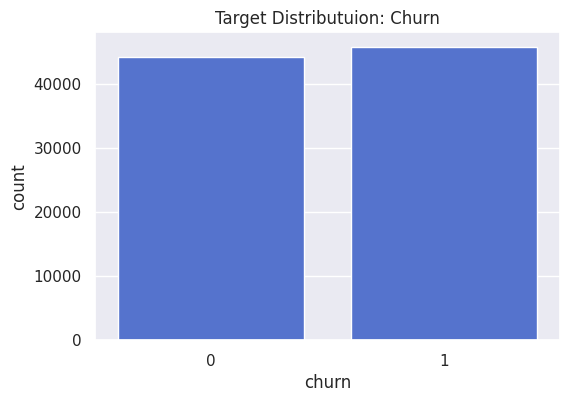

In [ ]:
sns.set()
plt.figure(figsize=[6,4])
sns.countplot(x=y,color='#4169E1')
plt.title('Target Distributuion: Churn')
plt.show()

In [ ]:
dif = (df['churn'].value_counts()[0]*100/len(df)) - (df['churn'].value_counts()[1]*100/len(df))
print(f'Diference between target values: {round(dif, 2)}')

Diference between target values: -1.78


# Undersampling (*)

**NOTA:** SOLO EN CLASIFICACIÓN cuando el ratio de éxitos está MUY DESBALANCEADO (<10%).


In [ ]:
if dif < 9:
  print(f'Ratio between target values: {round(dif, 2)}')
  print('Balanced')
else:
  print(f'Ratio between target values: {round(dif, 2)}')
  print('Unbalanced, proceed with undersampling')


Ratio between target values: -1.78
Balanced


# Split TRAIN-TEST

In [ ]:
# RANDOM HOLDOUT
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.30,stratify=y,random_state= 7)
print(f'Data divided: 30% for test')
print('Train data instances:', len(y_train))
print('Test data instances:', len(y_test))

Data divided: 30% for test
Train data instances: 63000
Test data instances: 27000


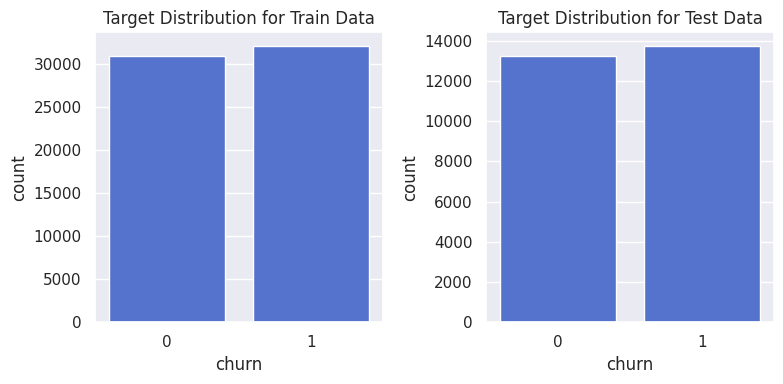

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
# Gráfico para y_train
sns.countplot(x=y_train, ax=axes[0], color='#4169E1')
axes[0].set_title('Target Distribution for Train Data')

# Gráfico para y_test
sns.countplot(x=y_test, ax=axes[1], color='#4169E1')
axes[1].set_title('Target Distribution for Test Data')

plt.tight_layout()
plt.show()

In [ ]:
# Distribucion en %
print(f'Target distribution for TRAIN data:')
print(f'{(y_train.value_counts() / len(y_train)*100).round()}')
print()
print(f'Target distribution for TEST data: ')
print(f'{(y_test.value_counts() / len(y_test)*100).round()}')

Target distribution for TRAIN data:
1    51.0
0    49.0
Name: churn, dtype: float64

Target distribution for TEST data: 
1    51.0
0    49.0
Name: churn, dtype: float64


# Rescaling

* NO NECESARIO en modelos de Arboles de Decisión.
* Guardar scaler en el model path.

*No se realiza reescaling, ya que todos los modelos testeados son basados en árboles.*

In [ ]:
print('CatBoost no necesita realizar un rescaling')

CatBoost no necesita realizar un rescaling


# TRAIN-VALIDA

## Torneo de Modelos

* Probamos una colección de modelos con el objetivo de conseguir el mejor rendimiento del modelo en los datos de VALIDACION.

In [ ]:
# Funcion que calcula el AUC de un modelo sobre un dataset (X-y)
def auc(model,X,y):
  model.fit(X,y)
  return roc_auc_score(y,model.predict_proba(X)[:,1])

# Funcion que calcula el AUC en Cross-Validation (X-y)
def auc_cross_validation(model,X,y):
  cross_val = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
  return cross_val.mean()

In [ ]:
label_, auc_train_ , auc_valida_ = [], [], []
def evaluate_classification(model, X, y, label=None):
  if label is None:
    label=str(model)
  label_.append(label)

  auc_train = auc(model,X,y)
  auc_valida = auc_cross_validation(model,X,y)
  auc_train_.append(auc_train)
  auc_valida_.append(auc_valida)

  return pd.DataFrame({'Model': label_,
                      'AUC Train': auc_train_,
                      'AUC Cross-Valida': auc_valida_
                      }).sort_values('AUC Cross-Valida',ascending=False)

In [ ]:
# CatBoostClassifier
CatBoostClassifier = CatBoostClassifier(verbose=False)
evaluate_classification(model = CatBoostClassifier,X=X_train, y=y_train)

,Model,AUC Train,AUC Cross-Valida
0,<catboost.core.CatBoostClassifier object at 0x...,0.809742,0.68399


In [ ]:
# XGBClassifier
evaluate_classification(model = XGBClassifier(),X=X_train, y=y_train)

,Model,AUC Train,AUC Cross-Valida
0,<catboost.core.CatBoostClassifier object at 0x...,0.809742,0.683990
1,"XGBClassifier(base_score=None, booster=None, c...",0.857407,0.665833


In [ ]:
# LGBMClassifier
evaluate_classification(model = LGBMClassifier(verbose=0),X=X_train, y=y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


,Model,AUC Train,AUC Cross-Valida
0,<catboost.core.CatBoostClassifier object at 0x...,0.809742,0.683990
2,LGBMClassifier(verbose=0),0.752489,0.677144
1,"XGBClassifier(base_score=None, booster=None, c...",0.857407,0.665833


In [ ]:
# GradientBoostingClassifier
evaluate_classification(model = GradientBoostingClassifier(),X=X_train, y=y_train)

,Model,AUC Train,AUC Cross-Valida
0,<catboost.core.CatBoostClassifier object at 0x...,0.809742,0.683990
2,LGBMClassifier(verbose=0),0.752489,0.677144
3,GradientBoostingClassifier(),0.691240,0.672798
1,"XGBClassifier(base_score=None, booster=None, c...",0.857407,0.665833


In [ ]:
# AdaBoostClassifier
evaluate_classification(model = AdaBoostClassifier(),X=X_train, y=y_train)

,Model,AUC Train,AUC Cross-Valida
0,<catboost.core.CatBoostClassifier object at 0x...,0.809742,0.683990
2,LGBMClassifier(verbose=0),0.752489,0.677144
3,GradientBoostingClassifier(),0.691240,0.672798
1,"XGBClassifier(base_score=None, booster=None, c...",0.857407,0.665833
4,AdaBoostClassifier(),0.665217,0.657732


* **MEJOR MODELO:** CatBoostClassifier es el modelo seleccionado. Es un modelo de clasificación basado en el enfoque de Gradient Boosting. Utilizamos un modelo de clasificación para predecir la probabilidad de churn de un cliente, que es un problema de clasificación binaria (churn o no churn). Los modelos de clasificación son comúnmente utilizados para este tipo de problemas donde se desea asignar una etiqueta (en este caso, churn o no churn) a una observación basada en características específicas.



## Hiperparametrizacion

* Utilizar RandomSearch para probar diferentes configuraciones de los parametros del modelo ganador en el torneo de modelos con el objetivo de mejorar el control del overfitting.

In [ ]:
# Definir los hiperparámetros y sus rangos
parameters_hp = {
    'learning_rate': [0.083,0.085],
    'depth': [5,6],
    'n_estimators': [513,516],
    'l2_leaf_reg': [32,33],
    'border_count': [83,84],
    'subsample': [0.95,0.96]
}

In [ ]:
# Random Search para buscar la mejor combinación de parámetros
search_hp = RandomizedSearchCV(estimator=CatBoostClassifier,
                               param_distributions = parameters_hp, scoring='roc_auc', cv = 4, n_iter = 30, n_jobs=-1, verbose=False)

In [ ]:
# Entrenar el modelo
search_hp.fit(X_train, y_train)

RandomizedSearchCV(cv=4,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7e8e25f32c80>,
                   n_iter=30, n_jobs=-1,
                   param_distributions={'border_count': [83, 84],
                                        'depth': [5, 6],
                                        'l2_leaf_reg': [32, 33],
                                        'learning_rate': [0.083, 0.085],
                                        'n_estimators': [513, 516],
                                        'subsample': [0.95, 0.96]},
                   scoring='roc_auc', verbose=False)

In [ ]:
print("---- Results from Random Search -----" )
print("\n The best estimator across ALL searched params:", search_hp.best_estimator_)
print("\n The best AUC:", -search_hp.best_score_)
print("\n The best parameters across ALL searched params: \n ", search_hp.best_params_)

---- Results from Random Search -----

 The best estimator across ALL searched params: <catboost.core.CatBoostClassifier object at 0x7e8e24f5fa60>

 The best AUC: -0.6836192965597392

 The best parameters across ALL searched params: 
  {'subsample': 0.95, 'n_estimators': 516, 'learning_rate': 0.085, 'l2_leaf_reg': 33, 'depth': 5, 'border_count': 84}


## Modelo final

* Entrenar el modelo final con el algoritmo y los parametros que hanfuncionado mejor en anteriores experimentos.
* Argumentar la elección.
* Guardar el modelo en model path.

El modelo hiperparametrizado no mejora la capacidad de generalización de acuerdo con los valores de AUC (0.6834). Al obtener un AUC más pequeño en los datos de validación, la diferencia con el AUC en los datos de TRAIN y VALIDACION se hace más grande y por lo tanto disminuye la capacidad de generalizar.

La decision de la elección se sustenta también en que al haber realizado validación cruzada obtenemos una estimación más confiable del rendimiendo del modelo.

In [ ]:
# Nos quedamos con el que no tiene hyperparametros
CatBoostClassifier_ = CatBoostClassifier

In [ ]:
# Training CatBoostClassifier_
evaluate_classification(label= 'Cat Boost', model = CatBoostClassifier_, X=X_train, y=y_train)

,Model,AUC Train,AUC Cross-Valida
0,<catboost.core.CatBoostClassifier object at 0x...,0.809742,0.683990
5,Cat Boost,0.809742,0.683990
2,LGBMClassifier(verbose=0),0.752489,0.677144
3,GradientBoostingClassifier(),0.691240,0.672798
1,"XGBClassifier(base_score=None, booster=None, c...",0.857407,0.665833
4,AdaBoostClassifier(),0.665217,0.657732


# TEST

* Evaluación de las métricas de performance en TEST.

In [ ]:
# Predicciones del modelo en los datos de TEST (validación)
y_test_pred = CatBoostClassifier.predict(X_test)

# Probabilidad de que sea un caso positivo (éxito) para cada una de las observaciones
y_test_pred_proba = CatBoostClassifier.predict_proba(X_test)[:, 1]

In [ ]:
# Predicciones del modelo en los datos de TRAIN
y_train_pred = CatBoostClassifier.predict(X_train)

# Probabilidad de que sea un caso positivo (éxito) para cada una de las observaciones
y_train_pred_proba = CatBoostClassifier.predict_proba(X_train)[:, 1]

In [ ]:
# AUC
auc_train = roc_auc_score(y_train, y_train_pred_proba)
auc_test = roc_auc_score(y_test, y_test_pred_proba)
print('AUC Train:', round(auc_train,4))
print('AUC Test:', round(auc_test,4))

AUC Train: 0.8097
AUC Test: 0.6826


In [ ]:
# ROC
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

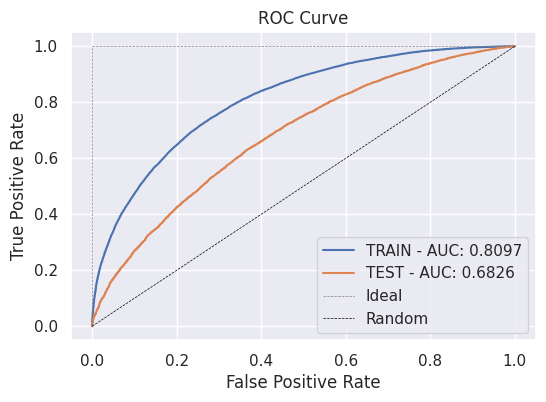

In [ ]:
# ROC Curve
plt.figure(figsize=[6,4])
plt.plot(fpr_train, tpr_train, label='TRAIN - AUC: {:.4f}'.format(auc_train))
plt.plot(fpr_test, tpr_test, label='TEST - AUC: {:.4f}'.format(auc_test))
plt.title('ROC Curve')
plt.plot([0,0,1],[0,1,1], color='grey', linestyle='--', linewidth=0.5, label='Ideal')
plt.plot([0, 1], [0, 1], color='black', linestyle='--', linewidth=0.5, label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

[]

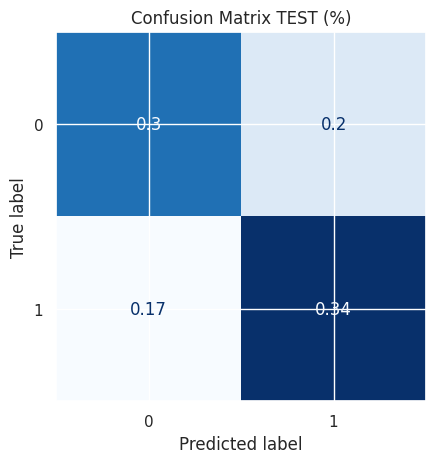

In [ ]:
# Confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(confusion_matrix=cm_test/len(y_test)).plot(colorbar = False, cmap = 'Blues')
plt.title('Confusion Matrix TEST (%)')
plt.plot()

In [ ]:
accuracy = round( accuracy_score(y_test, y_test_pred),4)
precision = round( precision_score(y_test, y_test_pred), 4)
recall = round( recall_score(y_test, y_test_pred), 4)
f1_value = round(f1_score(y_test, y_test_pred), 4)

metrics_df = pd.DataFrame({
    'Metrica': ['accuracy', 'precision', 'recall', 'f1_score'],
    'Valor': [accuracy, precision, recall, f1_value]
})
metrics_df

,Metrica,Valor
0,accuracy,0.6308
1,precision,0.6315
2,recall,0.6589
3,f1_score,0.6449


# INTERPRETABILITY

* Analizamos top features del modelo y su peso en el modelo.
* Plotear SHAP values y el impacto positivo/negativo.
* Comentar las top5 features, su impacto en el target y extraer insights.
* Analisis complementarios:
  * Modelos de arboles: Feature Importances, plot de arbol de decision.
  * Modelos lineales: Coeficentes y formula del modelo.

**SHAP VALUE**

In [ ]:
dic = pd.read_csv('/content/drive/MyDrive/DSC N°1123 - Entregable 2 - Julià_Tizzard_Quenti/data/variable_dictionary.csv')
var_shap = ['months','eqpdays','change_mou','mou','totmrc','drop_vce','avgqty','hnd_price','lor','avg_rev','avgmou','uniqsubs','avg3mou','mou_cvce','crclscod_E','iwylis_vce','asl_flag','avg3rev','mou_opkv','drop_blk']
pd.set_option('display.max_colwidth', None)
dic[dic['Variable'].isin(var_shap)]

,Variable,Description
1,mou,Mean number of monthly minutes of use
2,totmrc,Mean total monthly recurring charge
9,change_mou,Percentage change in monthly minutes of use vs previous three month average
11,drop_vce,Mean number of dropped (failed) voice calls
28,mou_cvce,Mean unrounded minutes of use of completed voice calls
33,iwylis_vce,Mean number of inbound wireless to wireless voice calls
41,mou_opkv,Mean unrounded minutes of use of off-peak voice calls
43,drop_blk,Mean number of dropped or blocked calls
49,months,Total number of months in service
50,uniqsubs,Number of unique subscribers in the household


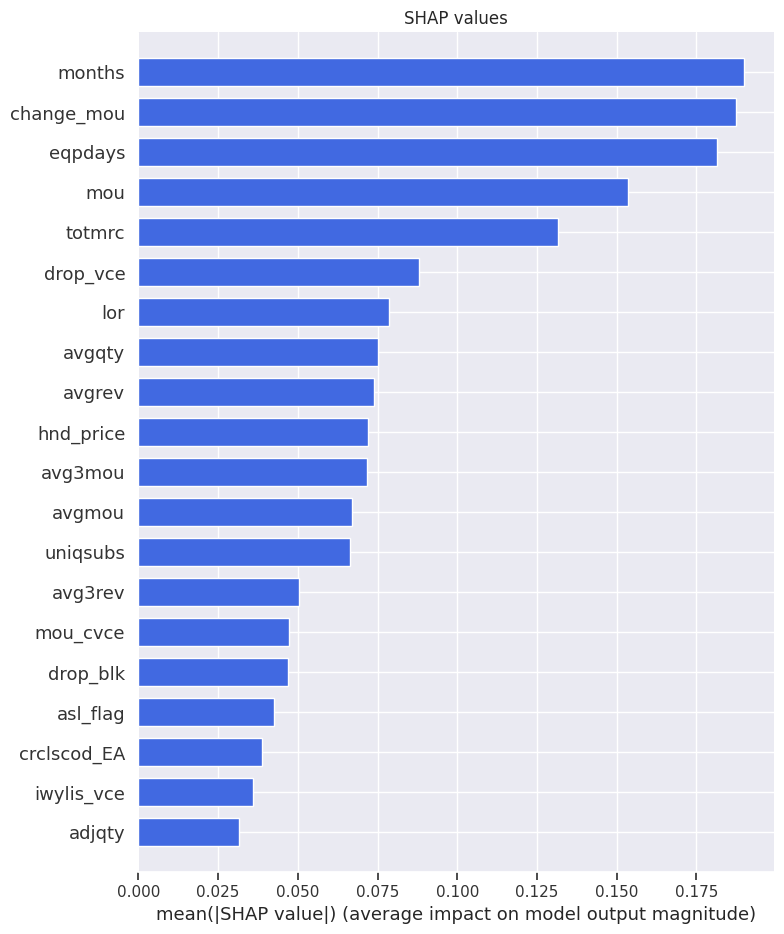

In [ ]:
# SHAP value
explainer = shap.TreeExplainer(CatBoostClassifier)
shap_values = explainer.shap_values(X_test)
plt.title('SHAP values')
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=20,color='#4169E1')

Luego hay que preguntarse si el impacto es positivo o es negativo, para lo cual nos apoyamos en el siguiente plot por puntos Los SHAP values nos indican ademas el sentido del impacto que tiene la variable en la predicción (positivo/negativo):

- Rojo a la derecha = POSITIVO (+)
- Rojo a la izquierda = NEGATIVO (-)

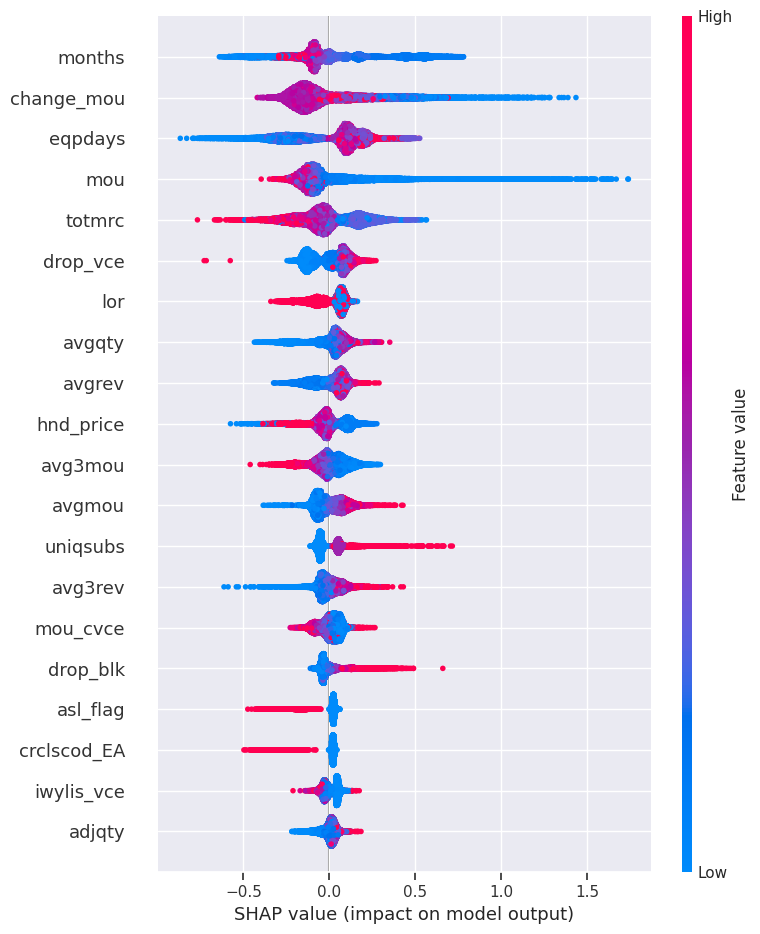

In [ ]:
shap.summary_plot(shap_values, X_test)

### Impacto positivo/negativo de las top 5 features en el churn.
Aportamos insights de negocio a partir de la lectura de los SHAP values.

1. **months**: impacto negativo
> Definición variable: Total number of months in service.
>>*'months' (meses que el cliente lleva con la compañía) tiene un SHAP negativo en el modelo de predicción, esto indica que, en promedio, un aumento en la cantidad de meses que el cliente lleva con la compañía está asociado con una disminución en la probabilidad de que el cliente se marche de la empresa (churn).*
>>> **Interpretación** Valor del Cliente a Largo Plazo: Los clientes que llevan más tiempo con la compañía pueden representar un valor a largo plazo. Pueden haber desarrollado una relación sólida con la empresa y estar más comprometidos, lo que reduce la probabilidad de churn.
2. **change_mou**: impacto negativo
> Definición variable: Percentage change in monthly minutes of use vs previous three month average.
>>*Si 'change_mou' (porcentaje de cambio en minutos de uso mensuales con respecto al promedio de los tres meses anteriores) tiene un SHAP negativo en el modelo de predicción, esto indica que, en promedio, un aumento en el cambio negativo en los minutos de uso mensuales está asociado con una disminución en la probabilidad de que el cliente se marche de la empresa (churn).*
>>> **Interpretación** Estabilidad en el Uso: Un cambio negativo en los minutos de uso mensuales podría indicar estabilidad en el comportamiento del cliente. Los clientes cuyo uso de minutos se mantiene constante o disminuye pueden ser menos propensos a abandonar la empresa.
3. **eqpdays**: impacto positivo
> Definición variable: Number of days (age) of current equipment.
>>*'eqpdays' Tiene un SHAP positivo en el modelo de predicción, esto indica que, en promedio, un aumento en la antigüedad del dispositivo está asociado con un aumento en la probabilidad de que el cliente se marche de la empresa (churn).*
>>> **Interpretación** Insatisfacción con el Dispositivo: Los clientes con dispositivos más antiguos podrían experimentar más problemas o tener una experiencia menos satisfactoria en comparación con aquellos con dispositivos más nuevos. Esto podría contribuir a una mayor probabilidad de churn.
4. **mou**: impacto negativo
> Definición variable: Mean number of monthly minutes of use.
>> *Un SHAP negativo para 'mou' indica que, en promedio, cuando los minutos de uso de móvil mensuales ('mou') aumentan, la probabilidad de churn tiende a disminuir. En otras palabras, clientes que utilizan más minutos de móvil al mes tienden a ser menos propensos a abandonar la empresa en comparación con aquellos que utilizan menos minutos.*
>>> **Interpretación** Lealtad del Cliente: Puede sugerir que los clientes que utilizan más minutos de móvil están más comprometidos o satisfechos con los servicios de la empresa, lo que podría aumentar su lealtad y reducir la probabilidad de churn.
5. **totmrc**: impacto negativo
> Definición variable: Mean total monthly recurring charge.
>>*Un SHAP value negativo significa que la presencia de 'totmrc' está contribuyendo negativamente a la predicción del modelo en términos de la probabilidad de churn. Es decir, cuando el valor de 'totmrc' es más alto, tiende a disminuir la probabilidad de que un cliente se vaya.*
>>> **Interpretación** En el contexto de este modelo de predicción de churn, una mayor 'totmrc' podría indicar que los clientes que tienen un mayor cargo mensual recurrente tienden a ser más leales o menos propensos a abandonar el servicio. Esto podría sugerir que los clientes que gastan más en servicios están más satisfechos.

# Guardar Modelo

In [ ]:
pickle.dump(CatBoostClassifier_, open('/content/drive/MyDrive/DSC N°1123 - Entregable 2 - Julià_Tizzard_Quenti/data/best_model.txt', 'wb'))